In [62]:
import gzip, os, random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from utils import Progbar
import math
%matplotlib inline
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

MNIST can be downloaded [here](http://yann.lecun.com/exdb/mnist/)

Training set contains 60, 000 images with labels

Testing set contains 10, 000 images with labeels

In [2]:
def load_data(filename, num_images=60000):
    #filename = os.path.join('data', 'train-images-idx3-ubyte.gz')
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(28 * 28 * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, 28, 28, 1)
    return data

data = load_data(os.path.join('data', 'train-images-idx3-ubyte.gz'))
print(data.shape)

def load_label(filename, num_images=60000):
    #filename = os.path.join('data', 'train-labels-idx1-ubyte.gz')
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

labels = load_label(filename = os.path.join('data', 'train-labels-idx1-ubyte.gz'))
print(labels.shape)

(60000, 28, 28, 1)
(60000,)


# Take a look at one image in the training set

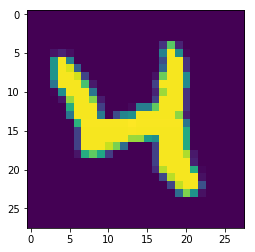

In [3]:
img = data[20].reshape(28,28)
plt.imshow(img)

In [4]:
lbl = labels[20]
print(lbl)

4


# Randomize the data

In [5]:
def get_indicis(data_size, batch_size, shuffle=True):
    indicis = np.arange(data_size)
    if shuffle:
        np.random.shuffle(indicis)
    for start_idx in range(0, data_size, batch_size):
        yield indicis[start_idx : start_idx + batch_size]
        
def load_mnist_data(data, labels, batch_size, shuffle=True):
    data_size = data.shape[0]
    for idx in get_indicis(data_size, batch_size, shuffle):
        yield data[idx], labels[idx]

# Define MNIST training model

A simple model:
CONV3 - MAX POOL - CONV3 - MAX POOL - FC

In [116]:
class MNIST_model(object):
    def __init__(self, num_classes, learning_rate=1e-3):
        tf.reset_default_graph()
        self.num_classes = num_classes
        self.lr = learning_rate
        self.input_placeholder = None
        self.label_placeholder = None
        self.training_placeholder = None
        self.hist = []
        self.build()
        
    def build(self):
        self.add_placeholders()
        self.pred = self.add_prediction_op()
        self.loss, self.corr, self.acc = self.add_loss_op(self.pred)
        self.train_op = self.add_train_op(self.loss)
        
    def add_placeholders(self):
        self.input_placeholder = tf.placeholder(tf.float32, shape=(None, 28, 28, 1))
        self.label_placeholder = tf.placeholder(tf.int64, shape=(None))
        self.training_placeholder = tf.placeholder(tf.bool)
        
    def add_loss_op(self, pred):
        '''
        '''
        y = self.label_placeholder
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
            labels=tf.one_hot(y, self.num_classes),
            logits = pred
        )
        loss = tf.reduce_mean(cross_entropy)
        
        correct_prediction = tf.equal(tf.argmax(pred, 1), y)
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
        return loss, correct_prediction, accuracy
        
    def add_train_op(self, loss):
        optimizer = tf.train.AdamOptimizer(learning_rate=self.lr)
        
        train_op = optimizer.minimize(loss)
        return train_op
    
    def create_feed_dict(self, inputs_batch, labels_batch=None, is_training=True):
        feed_dict = {
            self.input_placeholder : inputs_batch,
            self.training_placeholder : is_training,
        }
        if labels_batch is not None:
            feed_dict[self.label_placeholder] = labels_batch
        return feed_dict
    
    def train_on_batch(self, sess, inputs_batch, labels_batch=None, is_training=True):
        feed = self.create_feed_dict(inputs_batch, labels_batch, is_training)
        variables = [self.loss, self.corr, self.acc]
        if is_training:
            variables[-1] = self.train_op 
        loss, corr, _ = sess.run(variables, feed_dict=feed)
        
        return loss, corr
    
    def run_epoch(self, sess, batch_size, training_set, validation_set):
        X_tr, Y_tr = training_set
        
        prog = Progbar(target=int(math.ceil(X_tr.shape[0] / batch_size)))
        
        for i, (train_x, train_y) in enumerate(load_mnist_data(X_tr, Y_tr, batch_size)):
            loss, corr = self.train_on_batch(sess, train_x, train_y, True)
            prog.update(i + 1, [('train_loss', loss), ('train_acc', np.sum(corr)/train_x.shape[0])])
            
        X_val, Y_val = validation_set
            
        prog = Progbar(target=int(math.ceil(X_val.shape[0] / batch_size)))
        
        hist_input = []
        hist_pred = []
        for i, (val_x, val_y) in enumerate(load_mnist_data(X_val, Y_val, batch_size, shuffle=False)):
            loss, corr = self.train_on_batch(sess, val_x, val_y, is_training=False)
            hist_input += val_x.tolist()
            hist_pred += corr.tolist()
            prog.update(i + 1, [('val_loss', loss), ('val_acc', np.sum(corr)/val_x.shape[0])])
        self.hist = [(a,b) for a, b in zip(hist_input, hist_pred)]
            
    def fit(self, sess, epoches, batch_size, training_set, validation_set):
        for e in range(epoches):
            print("\nEpoch {:} / {:}".format(e + 1, epoches))
            self.run_epoch(sess, batch_size, training_set, validation_set)
            
    def add_prediction_op(self):
        '''
        Return predictions
        '''
        is_training = self.training_placeholder
        
        x = self.input_placeholder
        x = tf.contrib.layers.conv2d(
            inputs=x,
            num_outputs=10,
            kernel_size=3,
            padding='SAME',
            activation_fn=None
        ) # 28x28x10
        x = tf.contrib.layers.batch_norm(
            x,
            is_training=is_training
        )
        x = tf.nn.relu(x)
        x = tf.contrib.layers.max_pool2d(
            inputs=x,
            kernel_size=2,
            stride=2,
            padding='VALID'
        ) # 14x14x10
        
        x = tf.contrib.layers.conv2d(
            inputs=x,
            num_outputs=20,
            kernel_size=3,
            padding='SAME',
            activation_fn=None
        ) # 14x14x20
        x = tf.contrib.layers.batch_norm(
            x,
            is_training=is_training
        )
        x = tf.nn.relu(x)
        x = tf.contrib.layers.max_pool2d(
            inputs=x,
            kernel_size=2,
            stride=2,
            padding='VALID'
        ) # 7x7x20
        
        x = tf.contrib.layers.flatten(x)
        
        pred = tf.contrib.layers.fully_connected(
            x,
            self.num_classes,
            activation_fn=None
        )
        return pred
        
        
model = MNIST_model(10)

# Loading the testing data

(10000, 28, 28, 1)
(10000,)
9


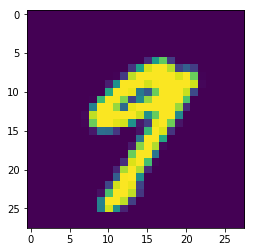

In [117]:
test_data = load_data(os.path.join('data', 't10k-images-idx3-ubyte.gz'), num_images=10000)
print(test_data.shape)
test_labels = load_label(os.path.join('data', 't10k-labels-idx1-ubyte.gz'), num_images=10000)
print(test_labels.shape)

img = test_data[20].reshape(28,28)
plt.imshow(img)
print(test_labels[20])

# Train the model

In [118]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [ ]:
model.fit(sess, 2, 16, (data, labels), (test_data, test_labels))


Epoch 1 / 1
1290/1875 [===================>..........] - ETA: 733s - train_loss: 0.0620 - train_acc: 0.9809

# Take a look at the wrong predictions

In [109]:
incorrect = [x[0] for i,x in enumerate(model.hist) if x[1] == False]

In [110]:
len(incorrect)

393

341


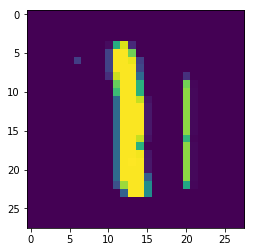

In [111]:
n = random.randint(0, len(incorrect))
print(n)
img = np.array(incorrect[n]).reshape(28,28)
plt.imshow(img)